# Processing/Regridding CESM inputs and outputs

---

## Regrid between rectilinear grids with xesmf

Regridding SE and FV output and emissions

Regridding CESM ocean T grids / U grids

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import matplotlib as mpl
import xarray as xr
import cartopy.crs as ccrs
import numpy as np

### Input data

In [2]:
data_vars = ['SST']
ds1 = xr.open_mfdataset("/glade/scratch/emmons/PYTHON_TUTORIAL/f.e21.FWHISTBgcCrop.f09_f09_mg17.CMIP6-AMIP-WACCM.001.cam.h0.2013-*.nc")
drop_vars = set(ds1.data_vars) - set(data_vars)
dset = ds1.drop(drop_vars).load()
dset

<xarray.Dataset>
Dimensions:  (ilev: 71, lat: 192, lev: 70, lon: 288, time: 12, zlon: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * zlon     (zlon) float64 0.0
  * lev      (lev) float64 5.96e-06 9.827e-06 1.62e-05 ... 957.5 976.3 992.6
  * ilev     (ilev) float64 4.5e-06 7.42e-06 1.223e-05 ... 967.5 985.1 1e+03
  * time     (time) object 2013-02-01 00:00:00 ... 2014-01-01 00:00:00
Data variables:
    SST      (time, lat, lon) float32 271.35 271.35 271.35 ... 271.35 271.35
Attributes:
    Conventions:       CF-1.0
    source:            CAM
    case:              f.e21.FWHISTBgcCrop.f09_f09_mg17.CMIP6-AMIP-WACCM.001
    logname:           cmip6
    host:              cheyenne2
    initial_file:      b.e21.BWHIST.f09_g17.CMIP6-historical-WACCM.001.cam.i....
    topography_file:   /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/fv_0.9x1...
    model_doi_url:  

In [3]:
dr = dset['SST'] # get a DataArray

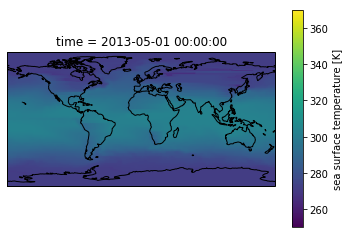

In [4]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr.isel(time=3).plot.pcolormesh(ax=ax, vmin=250, vmax=370, cmap='viridis');
ax.coastlines();

### Input grid

In [5]:
dset['lat'].data.shape, dset['lon'].data.shape

((192,), (288,))

### Output grid

Let's downsample our data to 0.5∘×0.5∘. Just define the output grid as an xarray 

In [6]:
dset_out = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 0.5)),
                     'lon': (['lon'], np.arange(0, 360, 0.5)),
                    }
                   )
dset_out

<xarray.Dataset>
Dimensions:  (lat: 360, lon: 720)
Coordinates:
  * lat      (lat) float64 -90.0 -89.5 -89.0 -88.5 -88.0 ... 88.0 88.5 89.0 89.5
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
Data variables:
    *empty*

### Perform regridding

Make a regridder by `xe.Regridder(grid_in, grid_out, method)`. `grid` is just an xarray DataSet containing lat and lon values.

In [7]:
import xesmf as xe

In [8]:
regridder = xe.Regridder(dset, dset_out, method='bilinear')
regridder

Overwrite existing file: bilinear_192x288_360x720.nc 
 You can set reuse_weights=True to save computing time.


xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_192x288_360x720.nc 
Reuse pre-computed weights? False 
Input grid shape:           (192, 288) 
Output grid shape:          (360, 720) 
Output grid dimension name: ('lat', 'lon') 
Periodic in longitude?      False

The regridder says it can transform data from shape (192, 288)  to shape (360, 720).

Once the regridder object is created, regridding our input `DataArray` is straightforward:

In [9]:
dr_out = regridder(dr)
dr_out

<xarray.DataArray 'SST' (time: 12, lat: 360, lon: 720)>
array([[[271.350006, 271.350006, ..., 271.350006, 271.350006],
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
        ...,
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
        [271.350006, 271.350006, ...,   0.      ,   0.      ]],

       [[271.350006, 271.350006, ..., 271.350006, 271.350006],
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
        ...,
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
        [271.350006, 271.350006, ...,   0.      ,   0.      ]],

       ...,

       [[271.350006, 271.350006, ..., 271.350006, 271.350006],
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
        ...,
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
        [271.350006, 271.350006, ...,   0.      ,   0.      ]],

       [[271.350006, 271.350006, ..., 271.350006, 271.350006],
        [271.350006, 271.350006, ...,   0.      ,   0.      ],
    

### Check results

The regridding result is consistent with the original data, with a much finer resolution:



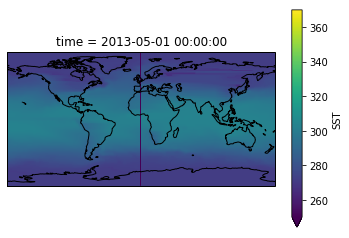

In [10]:
ax = plt.axes(projection=ccrs.PlateCarree())
dr_out.isel(time=3).plot.pcolormesh(ax=ax, vmin=250, vmax=370, cmap='viridis');
ax.coastlines();

### Broadcasting over extra dimensions
    
xESMF tracks coordinate values over extra dimensions, since horizontal regridding should not affect them.

In [11]:
dr_out['time']

<xarray.DataArray 'time' (time: 12)>
array([cftime.DatetimeNoLeap(2013, 2, 1, 0, 0, 0, 0, 0, 32),
       cftime.DatetimeNoLeap(2013, 3, 1, 0, 0, 0, 0, 0, 60),
       cftime.DatetimeNoLeap(2013, 4, 1, 0, 0, 0, 0, 3, 91),
       cftime.DatetimeNoLeap(2013, 5, 1, 0, 0, 0, 0, 5, 121),
       cftime.DatetimeNoLeap(2013, 6, 1, 0, 0, 0, 0, 1, 152),
       cftime.DatetimeNoLeap(2013, 7, 1, 0, 0, 0, 0, 3, 182),
       cftime.DatetimeNoLeap(2013, 8, 1, 0, 0, 0, 0, 6, 213),
       cftime.DatetimeNoLeap(2013, 9, 1, 0, 0, 0, 0, 2, 244),
       cftime.DatetimeNoLeap(2013, 10, 1, 0, 0, 0, 0, 4, 274),
       cftime.DatetimeNoLeap(2013, 11, 1, 0, 0, 0, 0, 0, 305),
       cftime.DatetimeNoLeap(2013, 12, 1, 0, 0, 0, 0, 2, 335),
       cftime.DatetimeNoLeap(2014, 1, 1, 0, 0, 0, 0, 5, 1)], dtype=object)
Coordinates:
  * time     (time) object 2013-02-01 00:00:00 ... 2014-01-01 00:00:00
Attributes:
    long_name:  time
    bounds:     time_bnds

In [12]:
# exactly the same as input
xr.testing.assert_identical(dr_out['time'], dset['time'])

We can plot the time series at a specific location, to make sure the broadcasting is correct:

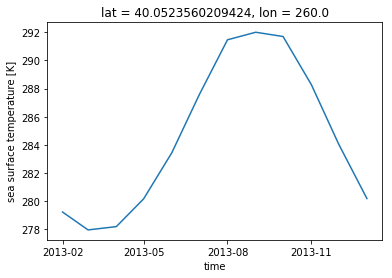

In [13]:
dr.sel(lon=260, lat=40, method='nearest').plot()  # input data

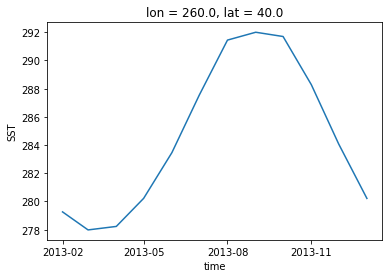

In [14]:
dr_out.sel(lon=260, lat=40, method='nearest').plot()

Calculate budgets, totals as in AMWG/Chemistry diagnostics

Creating timeseries from averages over regions